### Imports and definitions

In [1]:
from pickle_workaround import pickle_load
from TfidfVectorizer import TfidfVectorizer
from vectorizer import tokenize, extract_requirements
from nlp import get_top_10_docs
from topics import search_models, plot_results
from data import get_query_corpus, get_connection

import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from wordcloud import WordCloud

In [2]:
def topic_search(min_topics, max_topics, tfidf_corpus):

    time_start = time.time()
    costs, intertopic_similarities, interdocument_similarities = search_models(tfidf_corpus, min_topics, max_topics)
    time_dif = datetime.timedelta(seconds=round(time.time() - time_start))
    plot_results(min_topics, costs, intertopic_similarities, interdocument_similarities, time_dif, tfidf_corpus.shape)


def top10(topic_i, _W, _corpus):
    i = 1
    for doc, strength in get_top_10_docs(_W, topic_i):
        print(f"DOCUMENT #{i}")
        print("STRENGTH:", strength)
        print(_corpus[doc])
        print("*************************************************************\n")
        i += 1

In [3]:
_ = get_connection("/home/mark/Documents/missionmark/missionmark_db_creds")
tfidf = TfidfVectorizer(pickle_load("../output/CountVectorizer.pkl"), pickle_load("../output/TfidfTransformer.pkl"))
vocabulary = tfidf.get_feature_names()
print(len(vocabulary))

Connecting to Postgres database...
 -> Connection successful!
Loading ../output/CountVectorizer.pkl from cache...
 -> ../output/CountVectorizer.pkl loaded!
Loading ../output/TfidfTransformer.pkl from cache...
 -> ../output/TfidfTransformer.pkl loaded!
21384


# Finding and splitting the general construction topic

### Load dataset

In [8]:
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description LIKE('%REQUIREMENT%')
        """
doc_ids, corpus_full = get_query_corpus(query, True)
corpus = np.array([extract_requirements(doc) for doc in corpus_full])

Loading corpus...
 -> 8839 documents loaded!


In [9]:
# del corpus_full

In [10]:
tfidf_corpus = tfidf.transform(corpus)

nmf = pickle_load("../output/NMF.pkl")
H = nmf.components_
W = nmf.transform(tfidf_corpus)
W_max = W.max()

Loading ../output/NMF.pkl from cache...                                         
 -> ../output/NMF.pkl loaded!


### Find topics where "hvac" is significant

In [11]:
hvac_i = tfidf.vocabulary_["hvac"]
n_hvac_topics = np.count_nonzero(H[:, hvac_i])
hvac_topics = np.argsort(H[:, hvac_i])[::-1][:n_hvac_topics]
hvac_topics_strength = H[:, hvac_i].flatten()[hvac_topics]
for topic_i, strength in zip(hvac_topics, hvac_topics_strength):
    print(topic_i, "=", strength)

21 = 1.1010674634538637
43 = 0.131496124158824
4 = 0.035784489651780084


The term "hvac" is most significant in Topic 21 by a significant amount.  By reading the top ten documents for Topic 21, we can determine that it contains contracts for general construction tasks.
<br />
<br />

### Find other documents in Topic 26

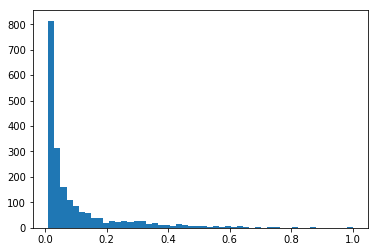

In [13]:
construction = W[:, 21]
construction /= construction.max()
_ = plt.hist(construction[construction > 0.01], bins=50)

In [14]:
threshold = .15
construction_tfidf = tfidf_corpus[construction > threshold]
construction_corpus = corpus[construction > threshold]
print(construction_tfidf.shape[0], "documents relating to construction.")

410 documents relating to construction.


### Determine the number of sub-topics to choose

Building NMF topics...


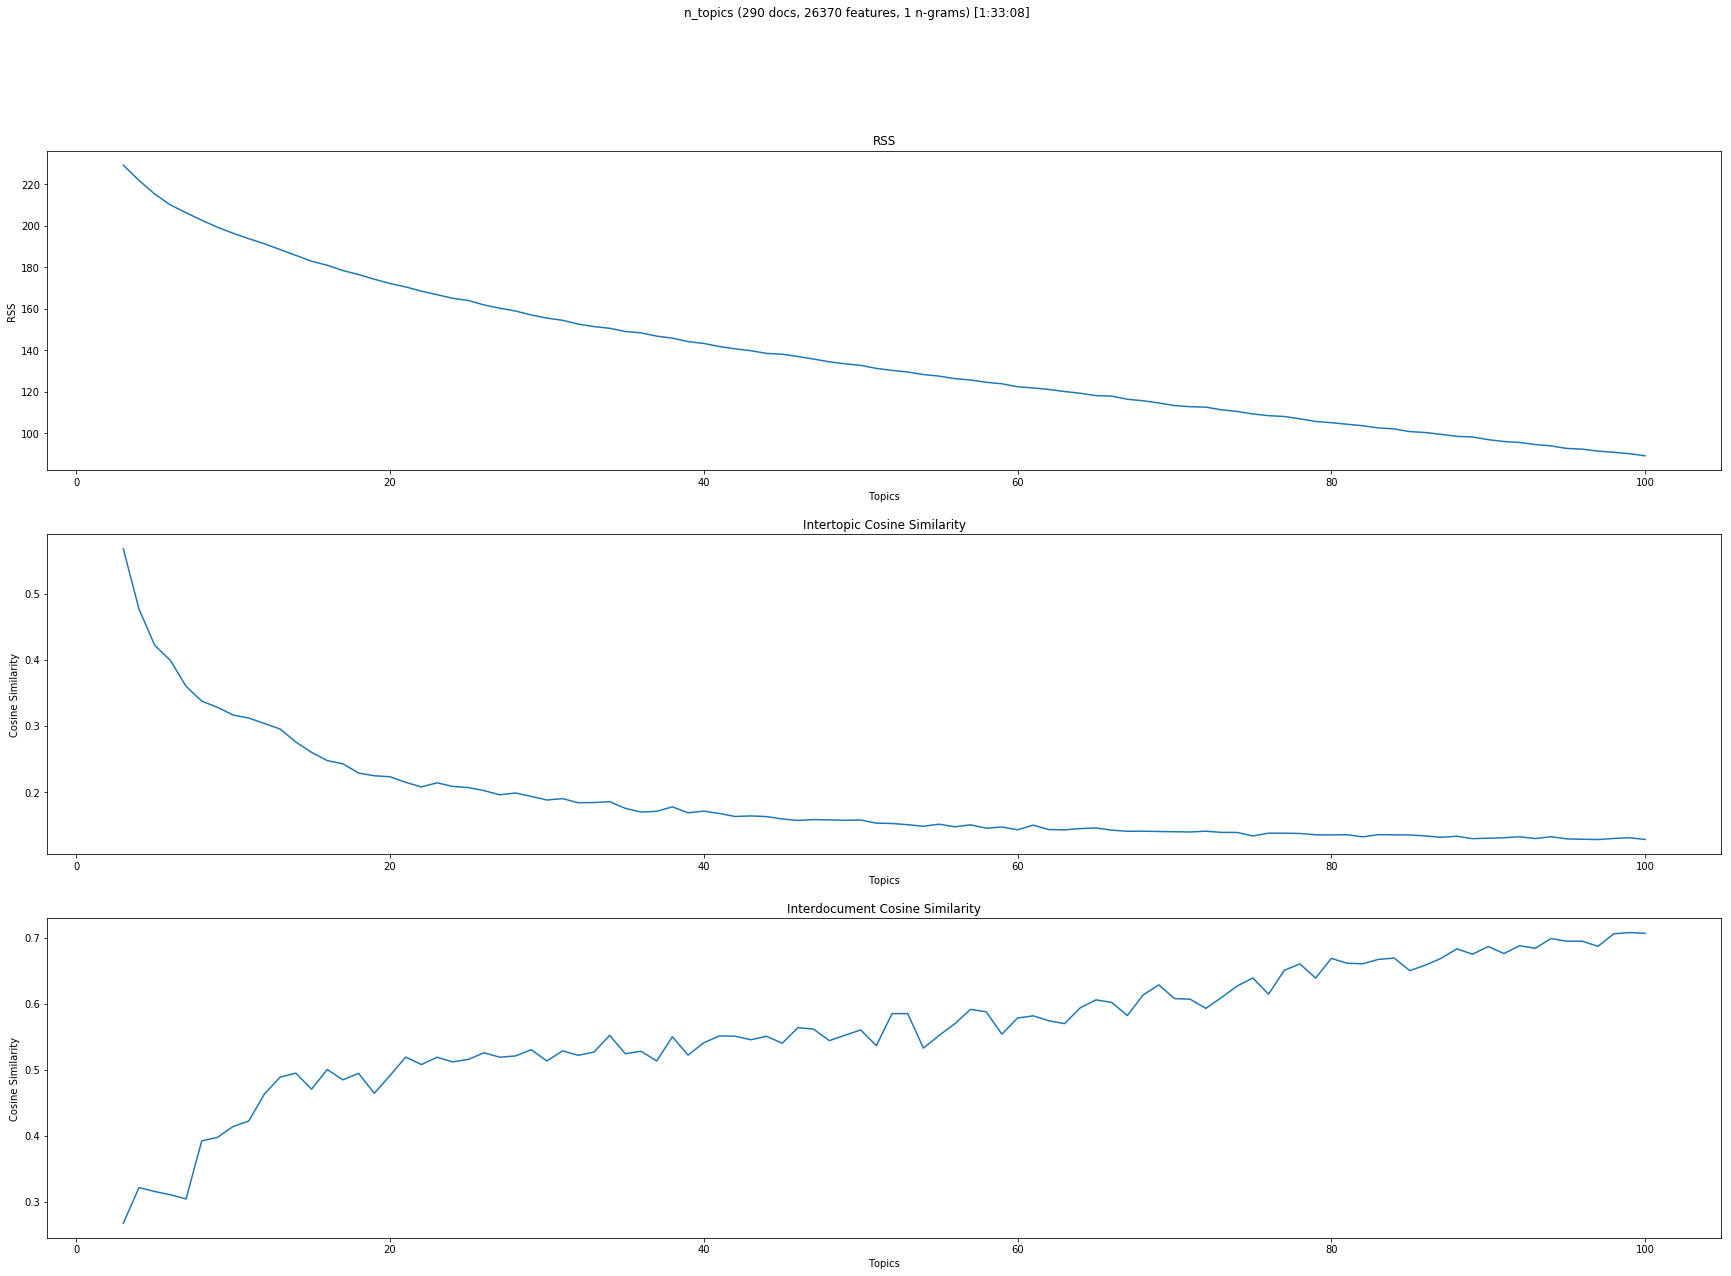

In [9]:
topic_search(3, 100, construction_tfidf)

In [16]:
construction_nmf = NMF(n_components=3, max_iter=666, random_state=666)
construction_W = construction_nmf.fit_transform(construction_tfidf)
construction_H = construction_nmf.components_
construction_W_max = construction_W.max()

In [17]:
hvac_i = tfidf.vocabulary_["hvac"]
n_hvac_topics = np.count_nonzero(construction_H[:, hvac_i])
hvac_topics = np.argsort(construction_H[:, hvac_i])[::-1][:n_hvac_topics]
hvac_topics_strength = construction_H[:, hvac_i].flatten()[hvac_topics]
for topic_i, strength in zip(hvac_topics, hvac_topics_strength):
    print(topic_i, "=", strength)

0 = 0.4372046267748558
1 = 0.2700499019894322


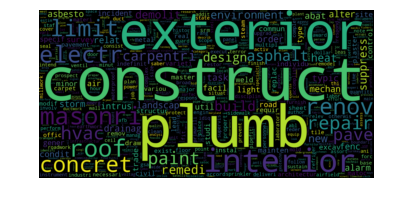

DOCUMENT #1
STRENGTH: 0.31983849271212
S  The contractor shall fulfill work included in the task orders may consist of multiple disciplines of construction, and shall include but not be limited to the following categories of work: construction, repair and alteration of facilities, interior and exterior renovations, heating and air-conditioning, HVAC controls, plumbing, fire suppression, interior and exterior electrical and lighting, fire and intrusion alarms, communications, limited utilities, site-work, landscaping, fencing, masonry, roofing, concrete, asphalt paving, painting, storm drainage, limited environmental remediation, concrete and asphalt paving, demolition of facilities, construction of new facilities, and other construction-related work 
*************************************************************

DOCUMENT #2
STRENGTH: 0.31782192447317736
S:  Typical work includes, but is not be limited to: interior and exterior renovations, heating and air-conditioning, HVAC controls, p

In [18]:
topic_i = 0
wc = WordCloud(background_color="black", max_words=666, width=2000, height=1000)
wc.fit_words({vocabulary[word_i]: construction_H[topic_i, word_i] for word_i in range(construction_H.shape[1]) if construction_H[topic_i, word_i]})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

top10(topic_i, construction_W, construction_corpus)

In [44]:
wc.to_image().show()

### Find other documents in the HVAC sub-topic

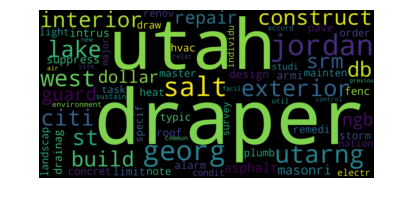

0 -> 0.0015412411464525637
1 -> 0.0
2 -> 0.5482003035399684
3 -> 0.0
4 -> 0.0
5 -> 0.04046329825192404
6 -> 0.0
7 -> 0.0
8 -> 0.0
9 -> 0.04907020691358635
 The Department of the Army, Army National Guard (NGB), Utah Army National Guard (UTARNG), may have a continuing requirement for design-build (DB) construction service for maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. PREVIOUS REQUIREMENTS  Maintenance, repair, construction and design-build services at Salt Lake City, Draper, West Jordan, and St. George, Utah. Typical work includes, but is not be limited to:  Interior and exterior renovations  Heating and air-conditioning  HVAC controls  Plumbing  Fire suppression  Interior and exterior electrical and lighting  Fire and intrusion alarms  Communications  Limited utilities  Site-work  Landscaping  Fencing  Masonry  Roofing  Concrete  Asphalt paving  Storm drainage  Limited environmental remediation  Constructio

In [37]:
doc_i = 2

wc = WordCloud(background_color="black", max_words=666, width=2000, height=1000)
wc.fit_words({vocabulary[word_i]: construction_tfidf[doc_i, word_i] for word_i in range(construction_tfidf.shape[1]) if construction_tfidf[doc_i, word_i]})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

doc = construction_corpus[doc_i]
doc_topics = construction_W[doc_i] / construction_W_max
[print(i, "->", x) for i, x in enumerate(doc_topics)]
print(doc)

In [38]:
wc.to_image().show()

# Build model from query

In [45]:
del doc_ids
del corpus
del tfidf_corpus
del nmf
del H
del W
del construction
del construction_nmf
del construction_tfidf
del construction_corpus

In [54]:
query = """
           SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description LIKE('%REQUIREMENTS%')
        """
doc_ids_query, corpus_query = get_query_corpus(query, True)
tfidf_corpus_query = tfidf.transform(corpus_query)

Loading corpus...
 -> 8780 documents loaded!


Building NMF topics...


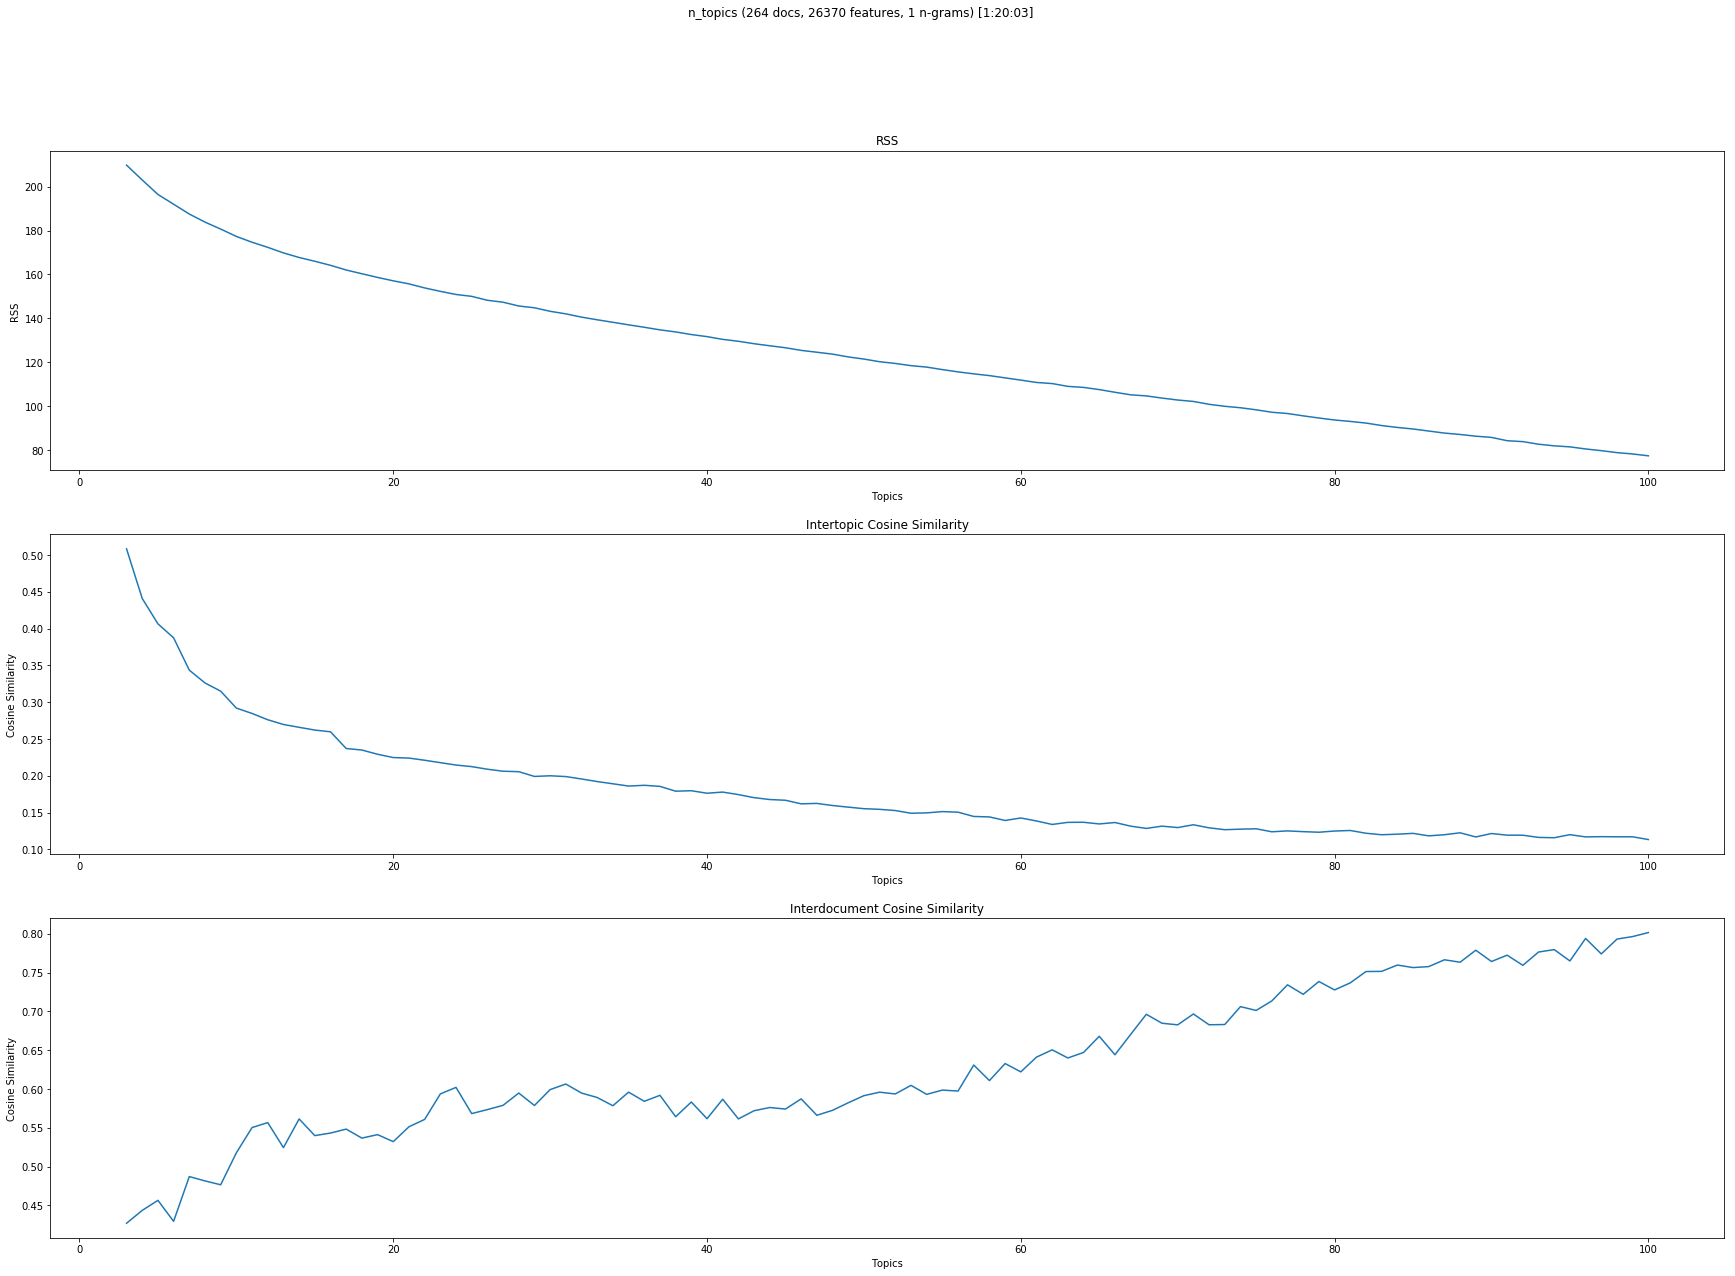

In [15]:
topic_search(3, 100, tfidf_corpus_query)

In [51]:
nmf_query = NMF(n_components=5, max_iter=666, random_state=666)
W_query = nmf_query.fit_transform(tfidf_corpus_query)
H_query = nmf_query.components_
W_max_query = W_query.max()

In [52]:
top10(4, W_query, corpus_query)

DOCUMENT #1
STRENGTH: 0.8759929659573683
 The Department of the Army, National Guard Bureau (NGB), Montana National Guard, has a requirement for general construction services for projects in the Great Falls, MT area. BACKGROUND The Air National Guard's federal mission is to maintain well-trained, well-equipped units available for prompt mobilization during war and provide assistance during national emergencies (such as natural disasters or civil disturbances). During peacetime, the combat-ready units and support units are assigned to most Air Force major commands to carry out missions compatible with training, mobilization readiness, humanitarian and contingency operations such as Operation Enduring Freedom in Afghanistan. Air National Guard units may be activated in a number of ways as prescribed by public law. REQUIREMENTS  Multiple Award Task Order Contract (MATOC)/Indefinite Delivery, Indefinite Quantity (IDIQ) for construction projects located on the Montana Air National Guard Bas